# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. Comma Separated fFile
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [131]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#from google.colab import drive
#drive.mount("/content/gdrive")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import  MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [132]:

# using the SQLite Table to read data.
# con = sqlite3.connect('/content/gdrive/My Drive/Amazon Fine Food Reviews/database.sqlite') 
con = sqlite3.connect("database.sqlite")
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and above 3 to be positive
actualScore = filtered_data['Score']
status = actualScore.map(partition) 
filtered_data['Score'] = status
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [133]:
# Which Product ID has more helpful review clicks than not helpful clicks?
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Time, Score, Text, COUNT(*)
FROM Reviews
WHERE HelpfulnessNumerator>HelpfulnessDenominator
""", con)

why did we not use groupby by productID in the above code?

In [134]:
print(display.shape)
display

(1, 9)


,UserId,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Text,COUNT(*)
0,A2V0I904FH7ABY,B001EQ55RW,Ram,3,2,1212883200,4,It was almost a 'love at first bite' - the per...,2


In [5]:
# How many users have written multiple reviews?
display2 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display2.shape)
display2

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2
...,...,...,...,...,...,...,...
80663,AZZNK89PXD006,B001J3ZUQ6,Etude,1269648000,5,In this package you get three varieties of pop...,6
80664,AZZTH6DJ0KSIP,B00014IVPQ,Crystal Caccamo,1304208000,5,ive bought a few different kinds and i feel th...,3
80665,AZZU1VEO8KUXH,B003FDC2I2,"Mia P ""Mia P""",1317513600,5,I bought this for my 13 year old daughter who ...,3
80666,AZZU4D6TZ2L6J,B0029XITW2,"Sherry King ""llamasmama""",1247875200,5,My father thought this was the best cheese eve...,2


In [7]:
# How many products have multiple reviews with a perfect score (Rating of 5)?
display3 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY ProductId
HAVING COUNT(*)>150 AND Score=5
""", con)

In [9]:
print(display3.shape)
display3

(296, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,ADODIH2V6UBQ9,7310172001,R. Miller,1315008000,5,By far this treat is the best one that I have ...,173
1,ADODIH2V6UBQ9,7310172101,R. Miller,1315008000,5,By far this treat is the best one that I have ...,173
2,A3KV0NO0TQTW3Y,B00004CI84,Tina,1349654400,5,I've always loved Beetlejuice and it's no surp...,189
3,A3KV0NO0TQTW3Y,B00004CXX9,Tina,1349654400,5,I've always loved Beetlejuice and it's no surp...,195
4,A3KV0NO0TQTW3Y,B00004RYGX,Tina,1349654400,5,I've always loved Beetlejuice and it's no surp...,189
...,...,...,...,...,...,...,...
291,A328X3XDGFFYIQ,B008ZRKZSM,Bryan K. Porter,1345334400,5,"Being that I am on a diet, ( As of Aug 19,2010...",310
292,A21VJBEVD3I967,B00954NY46,UAJPD,1329696000,5,Very good Bold coffee. Definitely not for the...,178
293,A21VJBEVD3I967,B00954NYVY,UAJPD,1329696000,5,Very good Bold coffee. Definitely not for the...,178
294,A22JFOTL40MXIO,B0098WV8F2,Maynarddawl,1346889600,5,Loved this product! For us who love peanut but...,215


In [10]:
# How many positive reviews are present in the dataset?
display4 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY ProductId
HAVING Score>3
""", con)

In [11]:
print(display4.shape)
display4

(51045, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,A25ACLV5KPB4W,0006641040,"Matt Hetling ""Matt""",1108425600,4,In June<br />I saw a charming group<br />of ro...,37
1,AB1A5EGHHVA9M,141278509X,CHelmic,1332547200,5,This product by Archer Farms is the best drink...,1
2,A1C298ITT645B6,2734888454,Hugh G. Pritchard,1195948800,5,Our dogs just love them. I saw them in a pet ...,2
3,A3QD68O22M2XHQ,2841233731,LABRNTH,1345852800,5,This book is easy to read and the ingredients ...,1
4,ADODIH2V6UBQ9,7310172001,R. Miller,1315008000,5,By far this treat is the best one that I have ...,173
...,...,...,...,...,...,...,...
51040,A35K4XT7T1ZIFU,B009SMKESO,Inez Rivera,1304985600,4,This review is for the boneless ham. A little ...,1
51041,A32A6X5KCP7ARG,B009SR4OQ2,sicamar,1350604800,5,I bought this Hazelnut Paste (Nocciola Spread)...,1
51042,ARL20DSHGVM1Y,B009UUS05I,Jamie,1331856000,5,The basket was the perfect sympathy gift when ...,1
51043,AMP7K1O84DH1T,B009WSNWC4,ESTY,1351209600,5,Purchased this product at a local store in NY ...,1


In [12]:
display5 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING Count(*)>2 AND Score>3
""", con)

In [13]:
print(display5.shape)
display5

(37702, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
1,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
2,#oc-R12MGTQS5KZZRV,B005HG9ET0,"SKY2110 ""SKY2110""",1344211200,5,This is the highest PH level I can find withou...,3
3,#oc-R14ZSRYW2YB41B,B005HG9ET0,A. Crafton,1346284800,5,I drank this on ice after a workout. It was ve...,3
4,#oc-R155JB2SA58E17,B005HG9ET0,Seanna,1347235200,5,"If you love bottled water, and are looking for...",3
...,...,...,...,...,...,...,...
37697,AZZJDUEFXYXBM,B000ER5D9W,J. Lewis,1284163200,4,My 6.5 month son enjoyed this flavor and it he...,4
37698,AZZNK89PXD006,B0039GMZZK,Etude,1269648000,5,Regular Chocolate Pocky is good on its own but...,6
37699,AZZTH6DJ0KSIP,B003Z4F56C,Crystal Caccamo,1337558400,5,i eat paleo so noodles are not allowed. i trie...,3
37700,AZZU1VEO8KUXH,B003FDG4K4,"Mia P ""Mia P""",1317513600,5,I bought this for my 13 year old daughter who ...,3


In [14]:
display6 = pd.read_sql_query("""
SELECT ProductId, Score, COUNT(ProductId) as Count
FROM Reviews
GROUP BY ProductId
ORDER BY Count Desc Limit 1
""", con)

In [15]:
display6

,ProductId,Score,Count
0,B007JFMH8M,5,913


In [16]:
display7 = pd.read_sql_query("""
SELECT ProductId, Score, COUNT(ProductId) as Count
FROM Reviews
GROUP BY ProductId
ORDER BY Count Asc Limit 1
""", con)
display7

,ProductId,Score,Count
0,141278509X,5,1


In [22]:
display['COUNT(*)'].sum()

2

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [23]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [135]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [136]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [137]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [138]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [139]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [140]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [141]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [143]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'html.parser')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [144]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [145]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [146]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [147]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [148]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [150]:
# Combining all the above statements
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [00:58<00:00, 793.25it/s]


In [151]:
preprocessed_summary = []
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 46071/46071 [01:07<00:00, 678.63it/s]


In [152]:
final["preprocessed_summary"] = preprocessed_summary
final["preprocessed_reviews"] = preprocessed_reviews
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_summary,preprocessed_reviews
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,made china,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog lover delites,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,thirty bucks,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,flies begone,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,wow make islickers,received shipment could hardly wait try produc...
...,...,...,...,...,...,...,...,...,...,...,...,...
29864,32540,B009NTCO4O,A2FO1R8FB6BLDI,V. Demand,10,10,1,1191283200,Yum Good,I have ordered this delicious cheesecake twice...,yum good,ordered delicious cheesecake twice time good r...
29869,32545,B009NTCO4O,A1SGWAO6PDKQ53,Female_Jedi_Master,1,1,1,1326412800,~Well received~,I purchased this to send as a gift and the rec...,well received,purchased send gift recipient loved taste par ...
35419,38512,B009O7B1I0,A2YWHBF45M64S2,EcyMom,0,0,0,1350864000,Reprehensible,This Trader Joe's product is good quality. Bu...,reprehensible,trader joe product good quality buy straight t...
1362,1478,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,0,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w...",weak coffee not good premium product price,coffee supposedly premium tastes watery thin n...


In [158]:
unigram_counts = CountVectorizer().fit_transform(final["preprocessed_reviews"].values)
print("Unigram Count: ", unigram_counts.get_shape())
print("Number of Unique Words: ", unigram_counts.get_shape()[1])

Unigram Count:  (46071, 39557)
Number of Unique Words:  39557


In [159]:
max_scaler = MaxAbsScaler()
standardized_data = max_scaler.fit_transform(unigram_counts).todense()
print(standardized_data.shape)

MemoryError: Unable to allocate 13.6 GiB for an array with shape (46071, 39557) and data type float64

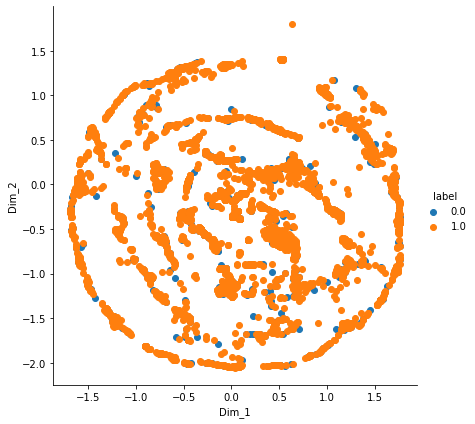

In [30]:
from sklearn.manifold import TSNE
from time import time
labels = final["Score"]
data_2000 = standardized_data[0:5000, 0]
labels_2000 = labels[0:5000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [160]:
final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [161]:
#split data into train, cross validate and test 
X = final['preprocessed_reviews']
Y = final['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [162]:
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [169]:
def Multinomial_Naive_Bayes(X_train, X_cv, Y_train, Y_cv):
    selected_lr = 0
    max_roc_auc = -1
    pred_cv = []
    pred_train = []
    possible_lr_list = [0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
    for i in possible_lr_list[-10:]:
        clf = MultinomialNB(alpha=i) # 0.00001
        clf.fit(X_train, Y_train)
        # clf.fit(X_train, y_train)
        # clf.predict(x_test, y_test)
        # clf.predict(X_cv)
        # We know naive bayes uses probability scores to predict on the test dataset or any unseen (validation data)
        probs = clf.predict_proba(X_cv)
        prob = clf.predict_proba(X_train)
        probs = probs[:,1]
        print(probs)
        prob = prob[:, 1]
        # Actual labels: X_cv, Y_cv
        auc_score_cv = roc_auc_score(Y_cv, probs)
        auc_score_train = roc_auc_score(Y_train, prob)
        print(i, " ------->>> Validation AUC-ROC ", auc_score_cv)
        print(i, " ------->>> Train AUC-ROC ", auc_score_train)

        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if max_roc_auc < auc_score_cv:
            max_roc_auc = auc_score_cv
            selected_lr = i
        print("\n The best learning rate selected is: ", max_roc_auc)
        sns.set_style("darkgrid")
        plt.xscale('log')

    plt.plot(possible_lr_list, pred_cv, 'r-', label="Cross Validation Data")
    plt.plot(possible_lr_list, pred_train, 'g-', label="Training Data")
    plt.legend(loc="upper right")
    plt.title(r'AUC Score V/S $selected_lr$')
    plt.xlabel(r"Learning Rates", fontsize=12)
    plt.ylabel("ROC AUC Score", fontsize=12)
    plt.show()
        
        # Calculate ROC Curve for the model:
        
    fpr, tpr, thresholds = roc_curve(Y_cv, probs)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker=".")
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [165]:
import scikitplot.metrics as skplt
from sklearn import metrics
def testing(X_train, Y_train, X_test, Y_test, optimal_lr):
    clf = MultinomialNB(optimal_lr, fit_prior=True, class_prior=None)
    clf.fit(X_train, Y_train)
    probs = clf.predict_proba(X_test)
    # Storing the probability values for positive outcomes
    probs = probs[:,1]
    print("AUC Score: ", roc_auc_score(Y_test, probs))
    fpr, tpr, thresholds = roc_curve(Y_test, probs)
    plt.plot([0,1], [0,1], linestyle="--")
    
    # Plot the ROC Curve for the model
    plt.plot(fpr, tpr, marker=".")
    plt.title("ROC Curve on Testing Data")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show
    prediction = clf.predict(X_test)
    skplt.plot_confusion_matrix(Y_test, prediction)
    print("F1 Score Macro: ", metrics.f1_score(Y_test, prediction, average='macro'))
    print("F1 Score Micro: ", metrics.f1_score(Y_test, prediction, average="micro"))
    print("hamming loss for data:", metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n", metrics.classification_report(Y_test, prediction))

In [166]:
# Bag of Words
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("Bag of Words Size: ",bow_train.get_shape())
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

Bag of Words Size:  (20680, 27495)
CV Data Size:  (10187, 27495)
Test Data Size:  (15204, 27495)


In [167]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ", bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (20680, 27495)
CV Data Size:  (10187, 27495)
Test Data Size:  (15204, 27495)


In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=777,k_neighbors=5)
bow_train,Y_tr = smote.fit_resample(bow_train,Y_tr)
bow_cv,Y_cv = smote.fit_resample(bow_cv,Y_cv)

In [95]:
from imblearn.combine import SMOTEENN
smenn = SMOTEENN()
bow_train, Y_tr = smenn.fit_resample(bow_train, Y_tr)
bow_cv, Y_cv = smote.fit_resample(bow_cv, Y_cv)

In [100]:
from imblearn.combine import SMOTETomek
smote = SMOTETomek(random_state=777)
bow_train,Y_tr = smote.fit_resample(bow_train,Y_tr)
bow_cv,Y_cv = smote.fit_resample(bow_cv,Y_cv)

In [103]:
from imblearn.over_sampling import ADASYN
smote = ADASYN(random_state=130)
bow_train,Y_tr = smote.fit_resample(bow_train,Y_tr)
bow_cv,Y_cv = smote.fit_resample(bow_cv,Y_cv)

[0.99556829 0.98838048 0.98126246 ... 0.99726647 0.94182814 0.98935227]
0.5  ------->>> Validation AUC-ROC  0.9220927944901746
0.5  ------->>> Train AUC-ROC  0.9460351337964967

 The best learning rate selected is:  0.9220927944901746
[0.97652431 0.96506553 0.97686575 ... 0.99248663 0.80589045 0.97910766]
0.1  ------->>> Validation AUC-ROC  0.9415690393993876
0.1  ------->>> Train AUC-ROC  0.9750517267995191

 The best learning rate selected is:  0.9415690393993876
[0.96995957 0.96037374 0.97882107 ... 0.99104421 0.77913977 0.98271605]
0.05  ------->>> Validation AUC-ROC  0.9413590893163841
0.05  ------->>> Train AUC-ROC  0.9806306602368398

 The best learning rate selected is:  0.9415690393993876
[0.96642116 0.96060862 0.98547478 ... 0.9895918  0.78158849 0.99318694]
0.01  ------->>> Validation AUC-ROC  0.9315570627667458
0.01  ------->>> Train AUC-ROC  0.9879211288562859

 The best learning rate selected is:  0.9415690393993876
[0.96753694 0.96259056 0.98802806 ... 0.98938798 0.79391

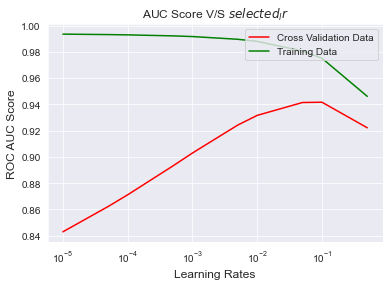

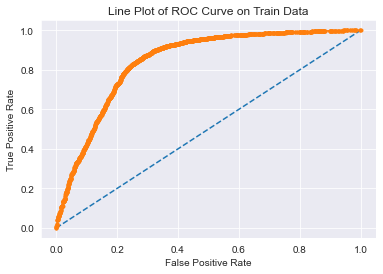

In [170]:
Multinomial_Naive_Bayes(bow_train,bow_cv,Y_tr,Y_cv)

AUC Score:  0.8694924731053862
F1 Score Macro:  0.4814927155251274
F1 Score Micro:  0.4968429360694554
hamming loss for data: 0.5031570639305446
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.25      0.98      0.39      2526
           1       0.99      0.40      0.57     12678

    accuracy                           0.50     15204
   macro avg       0.62      0.69      0.48     15204
weighted avg       0.87      0.50      0.54     15204



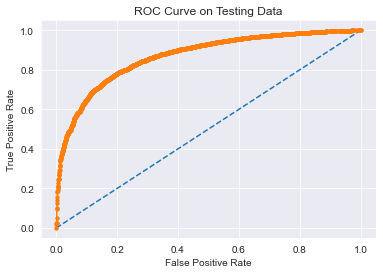

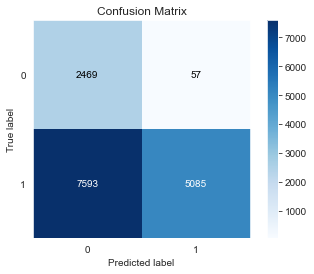

In [105]:
testing(bow_train,Y_tr,bow_test,Y_test,optimal_lr=0.9415690393993876)

In [44]:
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [45]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ", tfidf_cv.shape)
print("Test Data Size: ", tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (20680, 469501)
CV Data Size:  (10187, 469501)
Test Data Size:  (15204, 469501)


In [46]:
smote = SMOTE(random_state=777,k_neighbors=10)
tfidf_train,Y_tr = smote.fit_resample(tfidf_train,Y_tr)
tfidf_cv,Y_cv = smote.fit_resample(tfidf_cv,Y_cv)

In [47]:
tfidf_train = preprocessing.normalize(tfidf_train)
tfidf_cv=preprocessing.normalize(tfidf_cv)
tfidf_test=preprocessing.normalize(tfidf_test)
print("The shape of out tfidf vectorizer ", tfidf_train.get_shape())
print("CV Data Size: ", tfidf_cv.shape)
print("Test Data Size: ", tfidf_test.shape)

The shape of out tfidf vectorizer  (34482, 469501)
CV Data Size:  (17120, 469501)
Test Data Size:  (15204, 469501)


0.5  ------->>>  0.9688619366320204

 The best learning rate selected is:  0.9688619366320204
0.1  ------->>>  0.9510331142457856

 The best learning rate selected is:  0.9688619366320204
0.05  ------->>>  0.9389268576949952

 The best learning rate selected is:  0.9688619366320204
0.01  ------->>>  0.9070757544327015

 The best learning rate selected is:  0.9688619366320204
0.005  ------->>>  0.893722131845576

 The best learning rate selected is:  0.9688619366320204
0.001  ------->>>  0.8667626061773953

 The best learning rate selected is:  0.9688619366320204
0.0005  ------->>>  0.8570194039872479

 The best learning rate selected is:  0.9688619366320204
0.0001  ------->>>  0.8381949706306226

 The best learning rate selected is:  0.9688619366320204
5e-05  ------->>>  0.831467254236178

 The best learning rate selected is:  0.9688619366320204
1e-05  ------->>>  0.8182828058127347

 The best learning rate selected is:  0.9688619366320204


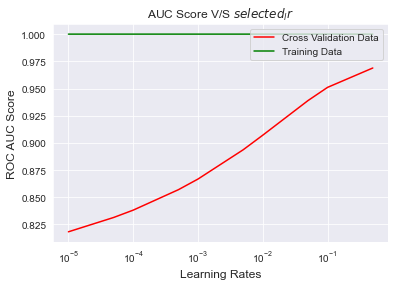

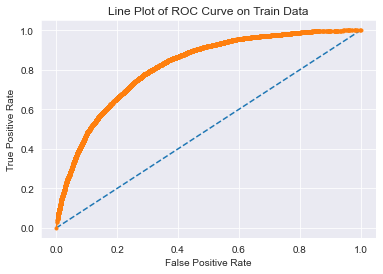

In [48]:
Multinomial_Naive_Bayes(tfidf_train, tfidf_cv, Y_tr, Y_cv)

AUC Score:  0.9492546486410398
F1 Score Macro:  0.7543790253560856
F1 Score Micro:  0.8166272033675348
hamming loss for data: 0.18337279663246514
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.47      0.94      0.63      2526
           1       0.99      0.79      0.88     12678

    accuracy                           0.82     15204
   macro avg       0.73      0.87      0.75     15204
weighted avg       0.90      0.82      0.84     15204



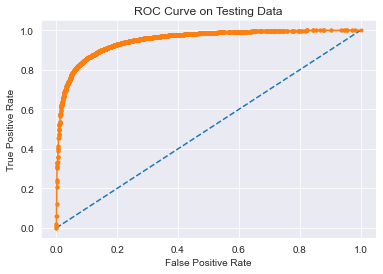

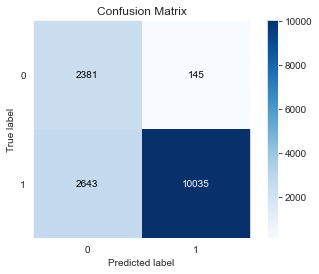

In [49]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_lr=0.9387873444042989)

0.5  ------->>>  0.9688619366320204

 The best learning rate selected is:  0.9688619366320204
0.1  ------->>>  0.9510331142457856

 The best learning rate selected is:  0.9688619366320204
0.05  ------->>>  0.9389268576949952

 The best learning rate selected is:  0.9688619366320204
0.01  ------->>>  0.9070757544327015

 The best learning rate selected is:  0.9688619366320204
0.005  ------->>>  0.893722131845576

 The best learning rate selected is:  0.9688619366320204
0.001  ------->>>  0.8667626061773953

 The best learning rate selected is:  0.9688619366320204
0.0005  ------->>>  0.8570194039872479

 The best learning rate selected is:  0.9688619366320204
0.0001  ------->>>  0.8381949706306226

 The best learning rate selected is:  0.9688619366320204
5e-05  ------->>>  0.831467254236178

 The best learning rate selected is:  0.9688619366320204
1e-05  ------->>>  0.8182828058127347

 The best learning rate selected is:  0.9688619366320204


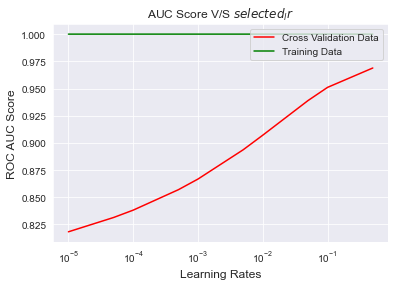

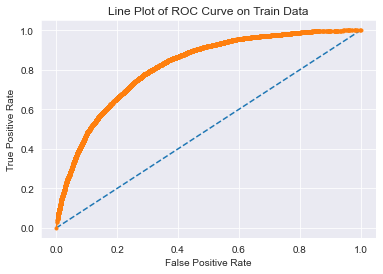

In [165]:
Multinomial_Naive_Bayes(tfidf_train, tfidf_cv, Y_tr, Y_cv)

AUC Score:  0.9492211431776818
F1 Score Macro:  0.7522364483164405
F1 Score Micro:  0.8141936332544067
hamming loss for data: 0.18580636674559325
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.47      0.95      0.63      2526
           1       0.99      0.79      0.88     12678

    accuracy                           0.81     15204
   macro avg       0.73      0.87      0.75     15204
weighted avg       0.90      0.81      0.83     15204



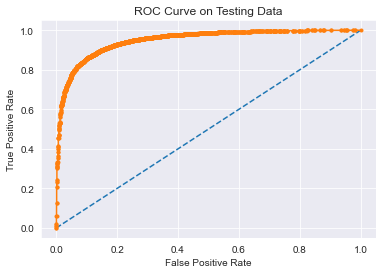

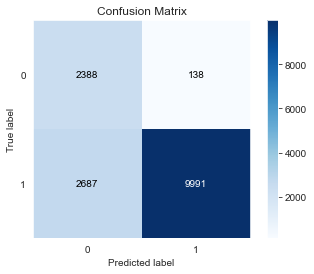

In [50]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_lr=0.9688619366320204)

In [51]:
from sklearn.linear_model import LogisticRegression

def logistic_l2(X_train, X_cv, Y_train, Y_cv):
    best_lr = 0
    max_roc_auc = -1
    pred_cv = []
    pred_train = []
    c = [0.5, 0.1, 0.05, 0.01, 0.001, 0.005]
    for i in c[-6:]:
        lr_clf = LogisticRegression(C=i, penalty='l2')
        lr_clf.fit(X_train, Y_train)
        probs = lr_clf.predict_proba(X_cv)
        prob = lr_clf.predict_proba(X_train)
        probs = probs[:, 1]
        prob = prob[:, 1]
        auc_score_cv = roc_auc_score(Y_cv, probs)
        auc_score_train = roc_auc_score(Y_train, prob)
        print(i, "For CV Data AUC Score is: ", auc_score_cv, "and for Train Data AUC Score is: ", auc_score_train)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if max_roc_auc < auc_score_cv:
            max_roc_auc = auc_score_cv
            best_c = i
    print(f"\n Best learning rate is {best_c} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale("log")
    plt.plot(c, pred_cv, 'r-', label="CV Data")
    plt.plot(c, pred_train, 'g-', label="Train Data")
    plt.title("AUC Score vs $lambda$")
    plt.xlabel("Learning Rate", fontsize=12)
    plt.ylabel("ROC AUC Score", fontsize=12)
    plt.show()
    
    fpr, tpr, thresholds = roc_curve(Y_train, prob)
    plt.plot(fpr, tpr, marker=".")
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [52]:
def testing_l2(X_train, Y_train, X_test, Y_test, optimal_lr):
    clf = LogisticRegression(C=optimal_lr, penalty='l2')
    clf.fit(X_train, Y_train)
    probs = clf.predict_proba(X_test)
    # Storing the probability values for positive outcomes
    probs = probs[:,1]
    print("AUC Score: ", roc_auc_score(Y_test, probs))
    fpr, tpr, thresholds = roc_curve(Y_test, probs)
    plt.plot([0,1], [0,1], linestyle="--")
    
    # Plot the ROC Curve for the model
    plt.plot(fpr, tpr, marker=".")
    plt.title("ROC Curve on Testing Data")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show
    prediction = clf.predict(X_test)
    skplt.plot_confusion_matrix(Y_test, prediction)
    print("F1 Score Macro: ", metrics.f1_score(Y_test, prediction, average='macro'))
    print("F1 Score Micro: ", metrics.f1_score(Y_test, prediction, average="micro"))
    print("hamming loss for data:", metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n", metrics.classification_report(Y_test, prediction))

0.5 For CV Data AUC Score is:  0.9676354375928029 and for Train Data AUC Score is:  0.9951728983858653
0.1 For CV Data AUC Score is:  0.9526256250545898 and for Train Data AUC Score is:  0.9769849550691623
0.05 For CV Data AUC Score is:  0.9453823887457418 and for Train Data AUC Score is:  0.9668878651180914
0.01 For CV Data AUC Score is:  0.9334640170538913 and for Train Data AUC Score is:  0.9500030548146104
0.001 For CV Data AUC Score is:  0.9287521290069003 and for Train Data AUC Score is:  0.9434398274237817
0.005 For CV Data AUC Score is:  0.9309970576032842 and for Train Data AUC Score is:  0.9465585238409148

 Best learning rate is 0.5 with highest roc_auc Score is 0.9676354375928029


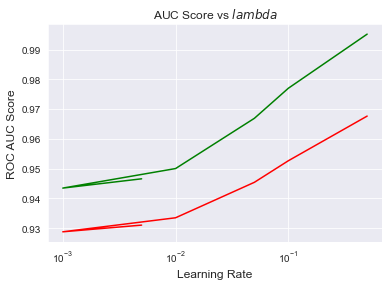

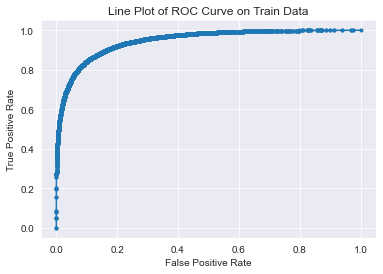

In [53]:
logistic_l2(tfidf_train, tfidf_cv, Y_tr, Y_cv)

AUC Score:  0.9363069572580203
F1 Score Macro:  0.8159426087090025
F1 Score Micro:  0.8889108129439621
hamming loss for data: 0.11108918705603789
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70      2526
           1       0.95      0.91      0.93     12678

    accuracy                           0.89     15204
   macro avg       0.79      0.85      0.82     15204
weighted avg       0.90      0.89      0.89     15204



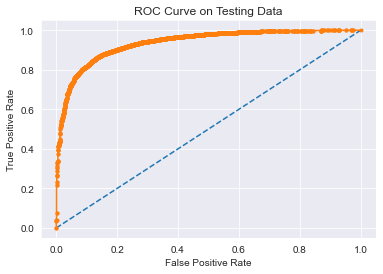

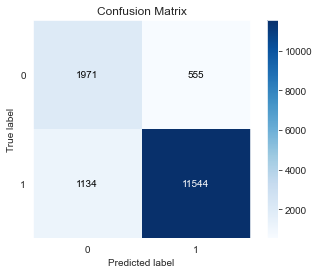

In [58]:
testing_l2(tfidf_train,Y_tr,tfidf_test,Y_test, optimal_lr=0.5)

In [64]:
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_summary,preprocessed_reviews
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,great product,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,wow make islickers,received shipment could hardly wait try produc...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",chewed gum many times used,nothing product bother link top page buy used ...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,best sugarless gum ever,love stuff sugar free not rot gums tastes good...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",limes rule,fresh limes underappreciated joy kitchen squir...
...,...,...,...,...,...,...,...,...,...,...,...,...
19181,20930,B001L1MKLY,A38XYFHXEUNUW6,bleaufire,0,0,1,1351209600,Yummy & Subtle,Just made my first pot of this wonderful coffe...,yummy subtle,made first pot wonderful coffee simply delish ...
14299,15604,B000255OIG,A3SSEJ8IEM4YGW,Seagaul,0,0,1,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",dogs love,gone treat dinner treat dogs work run chance l...
14300,15605,B000255OIG,AUINI96NMGXUI,Kkrys23,0,0,1,1351209600,Love this faucet,Love this faucet. My husband had installed th...,love faucet,love faucet husband installed one old house cu...
16026,17512,B0045Z6K50,A3HM6TNYB7FNDL,C. Furman,0,0,1,1351209600,Full- bodied without a bitter after-taste,This is my everyday coffee choice...a good all...,full bodied without bitter taste,everyday coffee choice good around crowd pleas...


In [118]:
X = final["preprocessed_reviews"]
y = final["Score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True)
print(y_train.shape)
X_t, X_cv, y_t, y_cv = train_test_split(X_train, y_train, test_size=0.20, shuffle=True)
print("Training Size: ", X_train.shape)
print("Test Size: ", X_test.shape)
print("Cross Validation Training Size: ", X_cv.shape)
print("Cross Validation Test Size: ", y_cv.shape)

(36856,)
Training Size:  (36856,)
Test Size:  (9215,)
Cross Validation Training Size:  (7372,)
Cross Validation Test Size:  (7372,)


In [119]:
tf_idf_vect = TfidfVectorizer(ngram_range=(2,3))
tfidf_train = tf_idf_vect.fit_transform(X_t)
print("The type of count vectorizer ", type(tfidf_train))
print("The shape of out text TFIDF vectorizer ", tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ", tfidf_cv.shape)
print("Test Data Size: ", tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (29484, 1592897)
CV Data Size:  (7372, 1592897)
Test Data Size:  (9215, 1592897)


In [126]:
from sklearn.ensemble import RandomForestClassifier
def RandomForest(X_train, X_cv, Y_train, Y_cv):
    selected_estimator = 0
    max_roc_auc = -1
    pred_cv = []
    pred_train = []
    possible_estimator_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for i in possible_estimator_list[-10:]:
        clf = RandomForestClassifier(n_estimators=i)
        clf.fit(X_train, Y_train)
        probs = clf.predict_proba(X_cv)
        prob = clf.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:, 1]
        auc_score_cv = roc_auc_score(Y_cv, probs)
        auc_score_train = roc_auc_score(Y_train, prob)
        print(i, " ------->>> ", auc_score_cv)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if max_roc_auc < auc_score_cv:
            max_roc_auc = auc_score_cv
            selected_estimator = i
        print("\n The best ROC AUC is: ", max_roc_auc)
        print("\n Suitable Estimator: ", selected_estimator)
        sns.set_style("darkgrid")
        plt.xscale('log')

    plt.plot(possible_estimator_list, pred_cv, 'r-', label="Cross Validation Data")
    plt.plot(possible_estimator_list, pred_train, 'g-', label="Training Data")
    plt.legend(loc="upper right")
    plt.title(r'AUC Score V/S $selected_lr$')
    plt.xlabel(r"n_estimators", fontsize=12)
    plt.ylabel("ROC AUC Score", fontsize=12)
    plt.show()
        
        # Calculate ROC Curve for the model:
        
    fpr, tpr, thresholds = roc_curve(Y_cv, probs)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker=".")
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [121]:
import scikitplot.metrics as skplt
from sklearn import metrics
def testing_rf(X_train, Y_train, X_test, Y_test, optimal_estimator):
    clf = RandomForestClassifier(optimal_estimator)
    clf.fit(X_train, Y_train)
    probs = clf.predict_proba(X_test)
    # Storing the probability values for positive outcomes
    probs = probs[:,1]
    print("AUC Score: ", roc_auc_score(Y_test, probs))
    fpr, tpr, thresholds = roc_curve(Y_test, probs)
    plt.plot([0,1], [0,1], linestyle="--")
    
    # Plot the ROC Curve for the model
    plt.plot(fpr, tpr, marker=".")
    plt.title("ROC Curve on Testing Data")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show
    prediction = clf.predict(X_test)
    skplt.plot_confusion_matrix(Y_test, prediction)
    print("F1 Score Macro: ", metrics.f1_score(Y_test, prediction, average='macro'))
    print("F1 Score Micro: ", metrics.f1_score(Y_test, prediction, average="micro"))
    print("hamming loss for data:", metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n", metrics.classification_report(Y_test, prediction))

10  ------->>>  0.7996532480601511

 The best ROC AUC is:  0.7996532480601511

 Suitable Estimator:  10
20  ------->>>  0.8327622039594434

 The best ROC AUC is:  0.8327622039594434

 Suitable Estimator:  20
30  ------->>>  0.8398342399674266

 The best ROC AUC is:  0.8398342399674266

 Suitable Estimator:  30
40  ------->>>  0.84534438910056

 The best ROC AUC is:  0.84534438910056

 Suitable Estimator:  40
50  ------->>>  0.8479036262199212

 The best ROC AUC is:  0.8479036262199212

 Suitable Estimator:  50
60  ------->>>  0.8513563119454185

 The best ROC AUC is:  0.8513563119454185

 Suitable Estimator:  60
70  ------->>>  0.8538267448091375

 The best ROC AUC is:  0.8538267448091375

 Suitable Estimator:  70
80  ------->>>  0.8504593691852002

 The best ROC AUC is:  0.8538267448091375

 Suitable Estimator:  70
90  ------->>>  0.8495172002042167

 The best ROC AUC is:  0.8538267448091375

 Suitable Estimator:  70
100  ------->>>  0.8520306836833289

 The best ROC AUC is:  0.853826

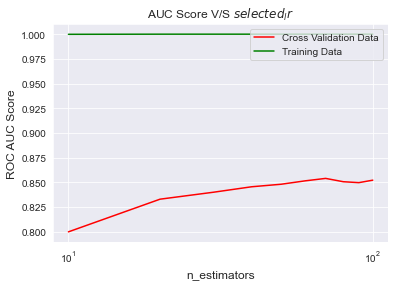

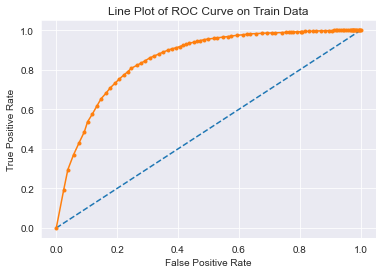

In [127]:
RandomForest(tfidf_train,tfidf_cv,y_t, y_cv)

AUC Score:  0.8547630069924976
F1 Score Macro:  0.6649726162992402
F1 Score Micro:  0.8683667932718394
hamming loss for data: 0.13163320672816062
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.83      0.27      0.40      1538
           1       0.87      0.99      0.93      7677

    accuracy                           0.87      9215
   macro avg       0.85      0.63      0.66      9215
weighted avg       0.86      0.87      0.84      9215



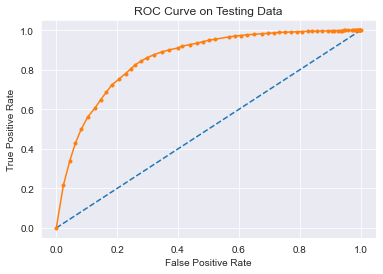

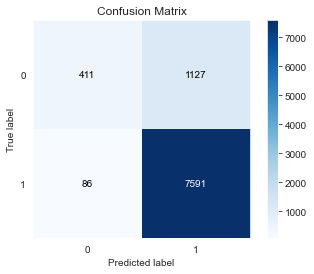

In [130]:
testing_rf(tfidf_train,y_t,tfidf_test,y_test, optimal_estimator=70)

In [72]:
def plot_loss(x_t, y_cv, y_t, ax, colors=['b']):
    fig,ax = plt.subplots(1,1)
    ax.plot(x_t, y_cv, 'b', label="Validation Loss")
    ax.plot(x_t, y_t, 'r', label="Training Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 10
batchsize = 64

final_output = pd.DataFrame(columns=["Model", "Architecture",
                                     "TRAIN_LOSS", "TEST_LOSS", "TRAIN_ACC", "TEST_ACC"]);

In [92]:
# create a LSTM Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

embed_vector_length = 32
model = keras.Sequential()
model.add(layers.Embedding(5000, embed_vector_length, input_length=1000))
model.add(layers.LSTM(100))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("***********************************************")
print("Printing the Model Summary")
print(model.summary())

NotImplementedError: Cannot convert a symbolic Tensor (lstm_2/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [93]:
!pip install numpy==1.15.3

    ERROR: Command errored out with exit status 1:
     command: 'c:\users\ya462zd\appdata\local\programs\python\python39\python.exe' 'c:\users\ya462zd\appdata\local\programs\python\python39\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' prepare_metadata_for_build_wheel 'C:\Users\YA462ZD\AppData\Local\Temp\tmpplu7149f'
         cwd: C:\Users\YA462ZD\AppData\Local\Temp\pip-install-zi0v27v3\numpy_8013429af8d94d57a762791f558b45b3
    Complete output (200 lines):
    Running from numpy source directory.
    setup.py:460: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
      run_build = parse_setuppy_commands()
    Processing numpy/random\_bounded_integers.pxd.in
    Processing numpy/random\bit_generator.pyx
    Processing numpy/random\mtrand.pyx
    Processing numpy/random\_bounded_integers.pyx.in
    Processing numpy/random\_common.pyx
    Processing numpy/random\_generator.pyx
    Processing numpy/random\_mt


  Using cached numpy-1.19.0.zip (7.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'error'


    Processing numpy/random\_pcg64.pyx
    Processing numpy/random\_philox.pyx
    Processing numpy/random\_sfc64.pyx
    Cythonizing sources
    blas_opt_info:
    blas_mkl_info:
    No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
    customize MSVCCompiler
      libraries mkl_rt not found in ['c:\\users\\ya462zd\\appdata\\local\\programs\\python\\python39\\lib', 'C:\\', 'c:\\users\\ya462zd\\appdata\\local\\programs\\python\\python39\\libs']
      NOT AVAILABLE
    
    blis_info:
      libraries blis not found in ['c:\\users\\ya462zd\\appdata\\local\\programs\\python\\python39\\lib', 'C:\\', 'c:\\users\\ya462zd\\appdata\\local\\programs\\python\\python39\\libs']
      NOT AVAILABLE
    
    openblas_info:
      libraries openblas not found in ['c:\\users\\ya462zd\\appdata\\local\\programs\\python\\python39\\lib', 'C:\\', 'c:\\users\\ya462zd\\appdata\\local\\programs\\python\\python39\\libs']
    get_default_fcompiler: matching types: '['gnu',

In [ ]:
m_hist = model.fit(tfidf_train, tfidf_test, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(tfidf_cv, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

final_output = final_output.append({"Model": 1,
                                    "Architecture": 'Embedding-LSTM-Sigmoid', 
                                    "TRAIN_LOSS": '{:.5f}'.format(m_hist.history["loss"][n_epochs-1]),
                                    "TEST_LOSS": '{:.5f}'.format(score[0]),
                                    "TRAIN_ACC": '{:.5f}'.format(m_hist.history["acc"][n_epochs-1]),
                                    "TEST_ACC": '{:.5f}'.format(score[1])}, ignore_index=True)

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,n_epochs+1))

vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)